<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h1>Business Problem</h1>
<h2>Description</h2>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>

*   List item
*   List item

<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>
<p> Download training_variants.zip and training_text.zip from Kaggle.</p> 

<h6>Context:</h6>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462</p>

<h6>Problem statement : </h6>
<p> Classify the given genetic variations/mutations based on evidence from text-based clinical literature. </p>

<h2>Source/Useful Links</h2>
Some articles and reference blogs about the problem statement.
1. https://www.forbes.com/sites/matthewherper/2017/06/03/a-new-cancer-drug-helped-almost-everyone-who-took-it-almost-heres-what-it-teaches-us/#2a44ee2f6b25
2. https://www.youtube.com/watch?v=UwbuW7oK8rk 
3. https://www.youtube.com/watch?v=qxXRKVompI8

<h2>Real-world/Business objectives and constraints.</h2>
* No low-latency requirement.</br>
* Interpretability is important.</br>
* Errors can be very costly.</br>
* Probability of a data-point belonging to each class is needed.</br>

<h1>Machine Learning Problem Formulation</h1>
<h2>Data</h2>
<h3>Data Overview</h3>
- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. </br>
- Both these data files are have a common column called ID</br>
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h3>Example Data Point</h3>

<h6>training_variants</h6>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h6> training_text</h6>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing  ... 

<h2>Mapping the real-world problem to an ML problem</h2>
<h3>Type of Machine Learning Problem</h3>
<p>
    There are nine different classes a genetic mutation can be classified into => Multi class classification problem
</p>
<h3>Performance Metric</h3>
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss</br>
* Confusion matrix</br> 

<h3>Machine Learing Objectives and Constraints</h3>
<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>
* Interpretability</br>
* Class probabilities are needed.</br>
* Penalize the errors in class probabilites => Metric is Log-loss.</br>
* No Latency constraints.</br>

<h2>Train, CV and Test Datasets</h2>
Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h1>3. Exploratory Data Analysis</h1>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

import re
import time
import math
import joblib
from collections import Counter, defaultdict

from nltk.corpus import stopwords

from imblearn.over_sampling import SMOTE

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, normalized_mutual_info_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

from mlxtend.classifier import StackingClassifier

<h2>Reading Data</h2>
<h3>Reading Gene and Variation Data</h3>

In [2]:
data = pd.read_csv('data/training_variants')

print(data.shape)
data.head(3)

(3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3>Reading Text Data</h3>

In [3]:
# note the seprator in this file
data_text = pd.read_csv("data/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

print(data_text.shape)
data_text.head(3)

(3321, 2)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


<h3>Preprocessing of text</h3>

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [6]:
# text processing stage.
start_time = time.time()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.time() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 49.21735215187073 seconds


In [7]:
# Merging both gene_variations and text data based on ID
result = pd.merge(data, data_text, on='ID', how='left')
result.head(3)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...


In [8]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
# remove nan value in text data
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] + ' ' + result['Variation']

result[result['ID'] == 1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [10]:
joblib.dump(result, "data/01_combined_data.csv")

['data/01_combined_data.csv']

## Analysis

In [11]:
data = joblib.load("data/01_combined_data.csv")

In [12]:
# Any space replace by '_'
data['Gene']      = data['Gene'].str.replace('\s+', '_')
data['Variation'] = data['Variation'].str.replace('\s+', '_')

Y = data['Class'].values
X = data
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [47]:
print('Number of data points in train data:', x_train.shape[0])
print('Number of data points in test data:', x_test.shape[0])
print('Number of data points in cross validation data:', x_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


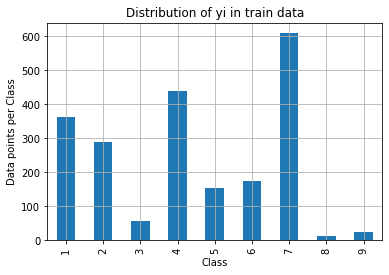

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


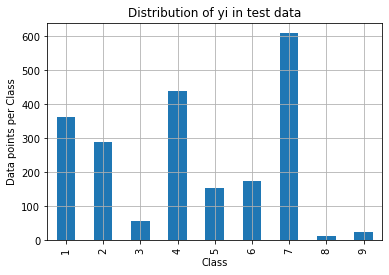

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


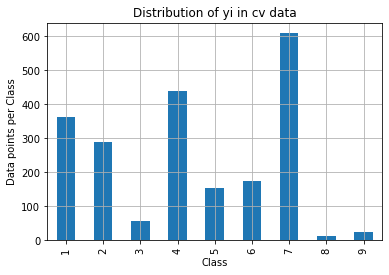

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)
--------------------------------------------------------------------------------


In [13]:
def display_distribution(class_distribution, split_data_type, data_shape):
    my_colors = 'rgbkymc'
    train_class_distribution.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title(f'Distribution of yi in {split_data_type} data')
    plt.grid()
    plt.show()
    
    # ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
    # -(class_distribution.values): the minus sign will give us in decreasing order
    sorted_yi = np.argsort(-class_distribution.values)
    for i in sorted_yi:
        print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/data_shape*100), 3), '%)')

    print('-'*80)

##########################################################    
##########################################################

# It returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = x_train['Class'].value_counts().sort_index()
display_distribution(class_distribution=train_class_distribution, split_data_type="train", data_shape=x_train.shape[0])

test_class_distribution = x_test['Class'].value_counts().sort_index()
display_distribution(class_distribution=test_class_distribution, split_data_type="test", data_shape=x_test.shape[0])

cv_class_distribution = x_cv['Class'].value_counts().sort_index()
display_distribution(class_distribution=cv_class_distribution, split_data_type="cv", data_shape=x_cv.shape[0])

In [14]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<h2>Prediction using a 'Random' Model</h2>
<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

Log loss on CV Data using Random Model 2.481684235642478
Log loss on test Data using Random Model 2.4673446852384124
-------------------- Confusion matrix --------------------


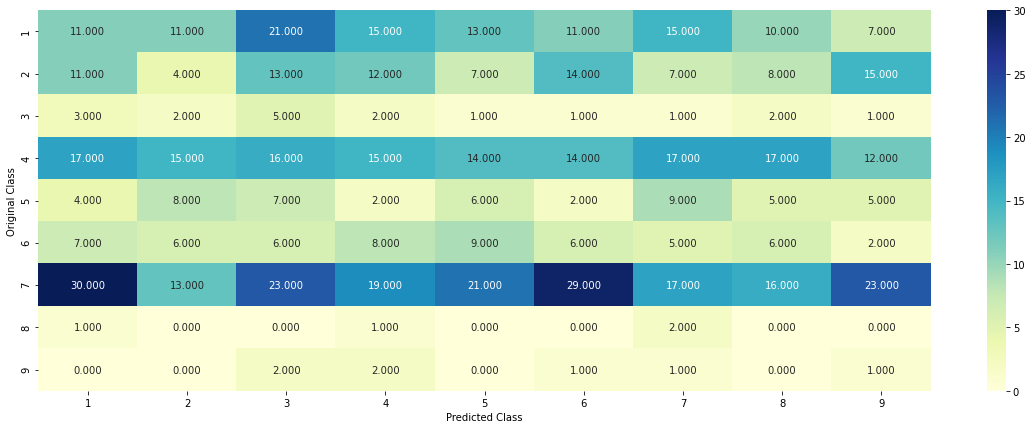

-------------------- Precision matrix (Columm Sum=1) --------------------


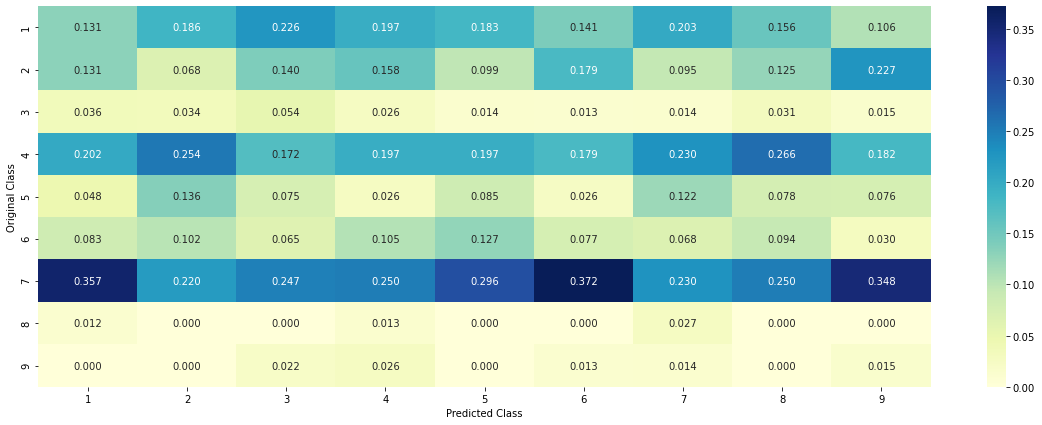

-------------------- Recall matrix (Row sum=1) --------------------


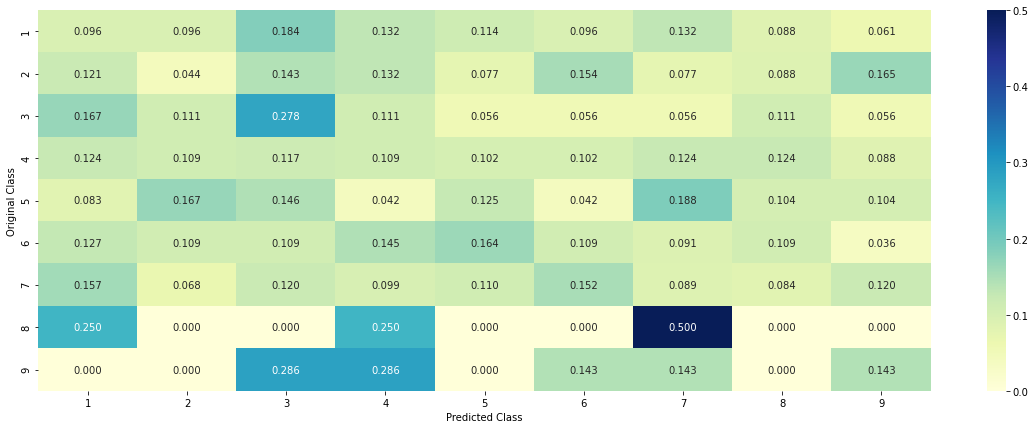

In [15]:
def random_model_test(split_data_type, df_splitted, test_data):
    # we need to generate 9 numbers and the sum of numbers should be 1
    # one solution is to genarate 9 numbers and divide each of the numbers by their sum
    # ref: https://stackoverflow.com/a/18662466/4084039
    data_len = df_splitted.shape[0]
    
    # we create a output array that has exactly same size as the data
    predicted_y = np.zeros((data_len,9))
    for i in range(data_len):
        rand_probs = np.random.rand(1, 9)
        predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    print(f"Log loss on {split_data_type} Data using Random Model", log_loss(test_data, predicted_y, eps=1e-15))
    
    if split_data_type == "test":
        predicted_y = np.argmax(predicted_y, axis=1)
        plot_confusion_matrix(test_data, predicted_y+1)
    
############################################
############################################
random_model_test(split_data_type="CV", df_splitted=x_cv, test_data=y_cv)
random_model_test(split_data_type="test", df_splitted=x_test, test_data=y_test)

#### CONCLUSION
Log loss on randon model = (2.437 CV) to (2.472 test)

Since, log-loss= [0, inf)</br>
thus, best model should give log-loss less than 2.437 atleast.

<h2>Univariate Analysis</h2>

In [16]:
# Code for Laplace smoothing.
# alpha/lambda : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']

# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

def get_gene_variation_features_dict(alpha, feature, df):
    """get_gv_fea_dict: Get gene varaition feature dict"""
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = x_train[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(x_train['Class']==1) & (x_train['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = x_train.loc[(x_train['Class']==k) & (x_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gene_variation_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gene_variation_features_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = x_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

When we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

<h3>Univariate Analysis on Gene Feature</h3>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [17]:
unique_genes = X['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 264
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64


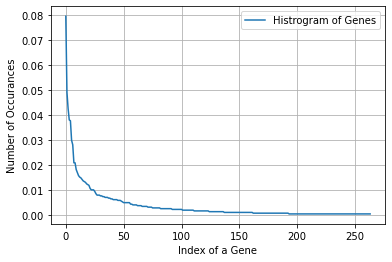

In [18]:
# Histogram on gens vs occurances

s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

#### CONCLUSION
1. One of the gene has occurance of 8%.
2. Few gene have high as well as low frequency.

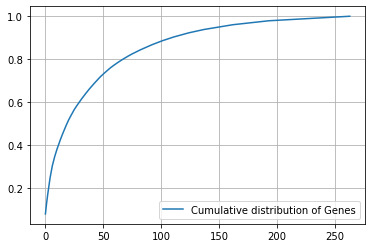

In [19]:
# Cummulative ratio of gene

c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

#### CONCLUSION
1. 60 to 65 genes haves 80% ratio while rest of 20% has remaining genes.

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b> As gene feature is cardinal, therefore; there are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding (Distance related algo i.e; log reg, lr-svm, knn, etc)</li><li>Response coding (non-linear model i.e; Tree algos, kernel-svm, etc)</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

### Response coding

In [20]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gene_variation_feature(alpha, "Gene", x_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gene_variation_feature(alpha, "Gene", x_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gene_variation_feature(alpha, "Gene", x_cv))

## Ans
print("train_gene_feature_responseCoding is converted feature using respone coding method.\n The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method.
 The shape of gene feature: (2124, 9)


### One-hotcode encoding

In [21]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

x_train['Gene'].head()

398       TP53
1343      AKT1
1678      FLT3
1680      FLT3
3093    NOTCH1
Name: Gene, dtype: object

In [22]:
print(gene_vectorizer.get_feature_names()[:10])

## Ans
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc', 'ar', 'araf']
train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 232)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.2286389861239067
For values of alpha =  0.0001 The log loss is: 1.2121253232733085
For values of alpha =  0.001 The log loss is: 1.2464972959796972
For values of alpha =  0.01 The log loss is: 1.3682983192404539
For values of alpha =  0.1 The log loss is: 1.4736771676572242
For values of alpha =  1 The log loss is: 1.5114913448968228


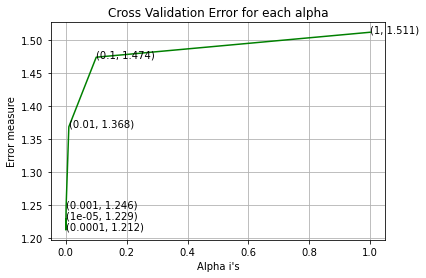

For values of best alpha =  0.0001 The train log loss is: 0.9918115756450787
For values of best alpha =  0.0001 The cross validation log loss is: 1.2121253232733085
For values of best alpha =  0.0001 The test log loss is: 1.1894997389839832


In [23]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

# Logistic regression

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

<p style="font-size:18px;"> <b>Q6.</b>How many data points in Test and CV datasets are covered by the genes in train dataset?
</p>

In [24]:
test_coverage=x_test[x_test['Gene'].isin(list(set(x_train['Gene'])))].shape[0]
cv_coverage=x_cv[x_cv['Gene'].isin(list(set(x_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

Ans
1. In test data 642 out of 665 : 96.54135338345866
2. In cross validation data 516 out of  532 : 96.99248120300751


#### CONCLUSION: Gene variable

1. Log loss
train: 0.98</br>
cv:    1.17</br>
test:  1.23</br>

<b>Result:</b> As logloss value is less than random model.</br>
    - gene onehotcodeencoding variable = IMPORTANT
    
2. Convergence/overlapping of data
cv:   96.69</br>
test: 96.99</br>

<b>Result:</b> As test & cv data has convergence very high.</br>
    - gene onehotcodeencoding variable = STABLE

<h3>Univariate Analysis on Variation Feature</h3>

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [25]:
unique_variations = x_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1934
Truncating_Mutations    55
Amplification           48
Deletion                46
Fusions                 22
Q61H                     3
Q61L                     3
Overexpression           3
Y64A                     2
T73I                     2
G13D                     2
Name: Variation, dtype: int64


In [26]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1934 different categories of variations in the train data, and they are distibuted as follows


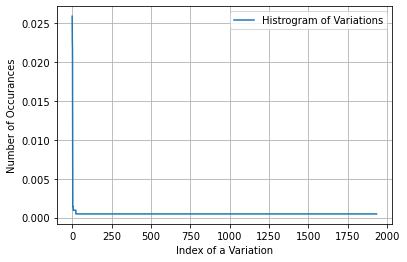

In [27]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

#### CONCLUSION: 
1. Most of the data points have frequency of 1 or 2.

[0.02589454 0.04849341 0.07015066 ... 0.99905838 0.99952919 1.        ]


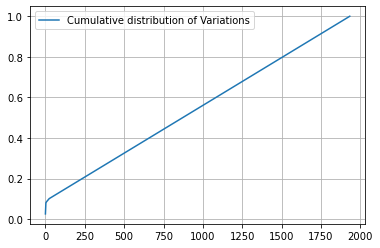

In [28]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

#### CONCLUSION: 
1. 80% of variation has 1500 variations approx.

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [29]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gene_variation_feature(alpha, "Variation", x_train))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gene_variation_feature(alpha, "Variation", x_test))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gene_variation_feature(alpha, "Variation", x_cv))

In [30]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [31]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])

# Ans
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1963)


<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.712129944889846
For values of alpha =  0.0001 The log loss is: 1.7028606233407604
For values of alpha =  0.001 The log loss is: 1.706001323101524
For values of alpha =  0.01 The log loss is: 1.7172263700092774
For values of alpha =  0.1 The log loss is: 1.7221457329963519
For values of alpha =  1 The log loss is: 1.7248843229411972


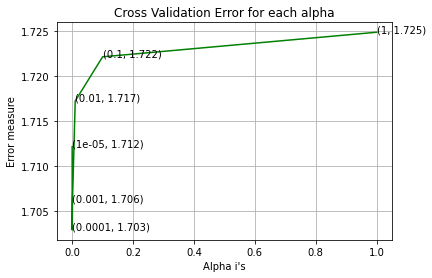

For values of best alpha =  0.0001 The train log loss is: 0.6596237597663619
For values of best alpha =  0.0001 The cross validation log loss is: 1.7028606233407604
For values of best alpha =  0.0001 The test log loss is: 1.6909003854770484


In [32]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

# Logistics regression: loss = sigmoid
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [33]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " variation in test and cross validation data sets?")
test_coverage=x_test[x_test['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
cv_coverage=x_cv[x_cv['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

Q12. How many data points are covered by total  1934  variation in test and cross validation data sets?
Ans
1. In test data 76 out of 665 : 11.428571428571429
2. In cross validation data 52 out of  532 : 9.774436090225564


#### CONCLUSION: Variation variable

1. Log loss
train: 0.70</br>
cv:    1.70</br>
test:  1.69</br>

<b>Result:</b> As logloss value is less than random model but fluctions in all datasets.</br>
    - gene onehotcodeencoding variable = IMPORTANT
    
2. Convergence/overlapping of data</br>
cv:   10.82</br>
test:  10.90</br>

<b>Result:</b> As test & cv data has convergence very high.</br>
    - gene onehotcodeencoding variable = LESS STABLE

<h3>Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [34]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [35]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [36]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
# One hotcode encoding == BOW in nlp 
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53251


In [37]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = x_train[x_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(x_train)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [38]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

In [39]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [40]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(x_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [41]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [42]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur[:5]))

Counter({153988: 1, 120068: 1, 81592: 1, 69603: 1, 68591: 1})


For values of alpha =  1e-05 The log loss is: 1.313994049499019
For values of alpha =  0.0001 The log loss is: 1.1934350915927276
For values of alpha =  0.001 The log loss is: 1.2110897141561776
For values of alpha =  0.01 The log loss is: 1.3244319529143245
For values of alpha =  0.1 The log loss is: 1.471167170822617
For values of alpha =  1 The log loss is: 1.640845002338313


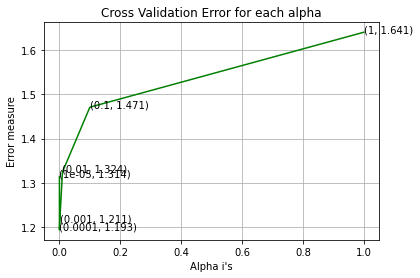

For values of best alpha =  0.0001 The train log loss is: 0.653073755418282
For values of best alpha =  0.0001 The cross validation log loss is: 1.1934350915927276
For values of best alpha =  0.0001 The test log loss is: 1.1662814691722572


In [43]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

# logistic regression
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [44]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [45]:
len1,len2 = get_intersec_text(x_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(x_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

95.641 % of word of test data appeared in train data
97.654 % of word of Cross Validation appeared in train data


#### CONCLUSION: text variable

1. Log loss</br>
train: 0.655</br>
cv:    1.145</br>
test:  1.075</br>

<b>Result:</b> As logloss value is less than random model but fluctions in all datasets.</br>
    - gene onehotcodeencoding variable = IMPORTANT</br>
    
2. Convergence/overlapping of data</br>
cv:   96.415</br>
test: 97.764</br>

<b>Result:</b> As test & cv data has convergence very high.</br>
    - gene onehotcodeencoding variable = STABLE

#### CONCLUSION: All variables

1. Log loss -> To check imp of variable

|            | gene   | variation   | text   |
|------------|--------|-------------|--------|
| train      | 0.98   | 0.70        | 0.65   |
| cv         | 1.17   | 1.70        | 1.14   |
| test       | 1.23   | 1.69        | 1.07   |
| Importance | HIGH   | LESS        | HIGH   |

2. Data convergence(overlap of data) -> To check stability of variables

|           | cv    | test  | convergence | Stability |
|-----------|-------|-------|-------------|-----------|
| gene      | 96.69 | 96.99 | v. high     | V. HIGH   |
| variation | 10.82 | 10.90 | v. low      | L. LOW    |
| text      | 96.41 | 97.76 | v. high     | V. HIGH   |


<b>Result</b>:

| variables | Importance order |
|-----------|------------------|
|    text   |         1        |
|    gene   |         2        |
| variation |         3        |

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [51]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(x_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(x_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(x_cv['Class']))

print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55446)
(number of data points * number of features) in test data =  (665, 55446)
(number of data points * number of features) in cross validation data = (532, 55446)


In [52]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


In [56]:
# Onehotcode
# Train 
joblib.dump(train_x_onehotCoding, "data/01_hotcodeencoding/01_train_x.joblib")
# Test
joblib.dump(test_x_onehotCoding, "data/01_hotcodeencoding/02_test_x.joblib")
# CV
joblib.dump(cv_x_onehotCoding, "data/01_hotcodeencoding/03_cv_x.joblib")

# Response
# Train 
joblib.dump(train_x_responseCoding, "data/02_responsecoding/01_train_x.joblib")
# Test
joblib.dump(test_x_responseCoding, "data/02_responsecoding/02_test_x.joblib")
# CV
joblib.dump(cv_x_responseCoding, "data/02_responsecoding/03_cv_x.joblib")


# Label
# Train
joblib.dump(train_y, "data/03_label/01_train_y.joblib")
# Test
joblib.dump(test_y, "data/03_label/02_test_y.joblib")
# CV
joblib.dump(cv_y, "data/03_label/01_cv_y.joblib")

['data/03_label/01_cv_y.joblib']